## Accessing GPM-IMERG data with the Planetary Computer STAC API

The [Integrated Multi-satellitE Retrievals for GPM (IMERG) dataset](http://planetarycomputer.microsoft.com/dataset/gpm-imerg) combines information from the [GPM satellite constellation](https://gpm.nasa.gov/missions/gpm/constellation) to estimate precipitation over the majority of the Earth's surface. This algorithm is particularly valuable over the majority of the Earth's surface that lacks precipitation-measuring instruments on the ground. Now in the latest Version 06 release of IMERG the algorithm fuses the early precipitation estimates collected during the operation of the TRMM satellite (2000 - 2015) with more recent precipitation estimates collected during operation of the GPM satellite (2014 - present). The longer the record, the more valuable it is, as researchers and application developers will attest. By being able to compare and contrast past and present data, researchers are better informed to make climate and weather models more accurate, better understand normal and extreme rain and snowfall around the world, and strengthen applications for current and future disasters, disease, resource management, energy production and food security.

For more, see the [IMERG homepage](https://gpm.nasa.gov/data/imerg).

The data are provided in [Zarr](https://zarr.readthedocs.io/) format, and cover June 2000 – May 2021.

In [1]:
import xarray as xr
import pystac_client
import fsspec
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
imerg = catalog.get_collection("gpm-imerg-hhr")
imerg

<CollectionClient id=gpm-imerg-hhr>

This collection has a single asset, which links to the Zarr store in Azure Blob Storage.

In [2]:
asset = planetary_computer.sign(imerg.assets["zarr-abfs"])
fs = fsspec.get_mapper(asset.href, **asset.extra_fields["xarray:storage_options"])
ds = xr.open_zarr(fs, **asset.extra_fields["xarray:open_kwargs"])
ds

<xarray.Dataset>
Dimensions:                         (time: 368160, lon: 3600, lat: 1800, latv: 2, lonv: 2, nv: 2)
Coordinates:
  * lat                             (lat) float32 -89.95 -89.85 ... 89.85 89.95
    lat_bnds                        (lat, latv) float32 dask.array<chunksize=(1800, 2), meta=np.ndarray>
  * lon                             (lon) float32 -179.9 -179.9 ... 179.9 179.9
    lon_bnds                        (lon, lonv) float32 dask.array<chunksize=(3600, 2), meta=np.ndarray>
  * time                            (time) object 2000-06-01 00:00:00 ... 202...
    time_bnds                       (time, nv) object dask.array<chunksize=(12, 2), meta=np.ndarray>
Dimensions without coordinates: latv, lonv, nv
Data variables:
    HQobservationTime               (time, lon, lat) timedelta64[ns] dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    HQprecipSource                  (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    HQprecipitation                 (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    IRkalmanFilterWeight            (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    IRprecipitation                 (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    precipitationCal                (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    precipitationQualityIndex       (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    precipitationUncal              (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
    randomError                     (time, lon, lat) float32 dask.array<chunksize=(12, 3600, 1800), meta=np.ndarray>
Attributes:
    GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatitudeRe...

This dataset includes timeseries for a handful of variables. We'll select one day's worth of data for `precipitationCal`, which contains the Multi-satellite precipitation estimate with gauge calibration.

In [3]:
day = ds.precipitationCal.sel(time="2015-01-01").compute()

We can plot the precipitation at a single timestamp using matplotlib.

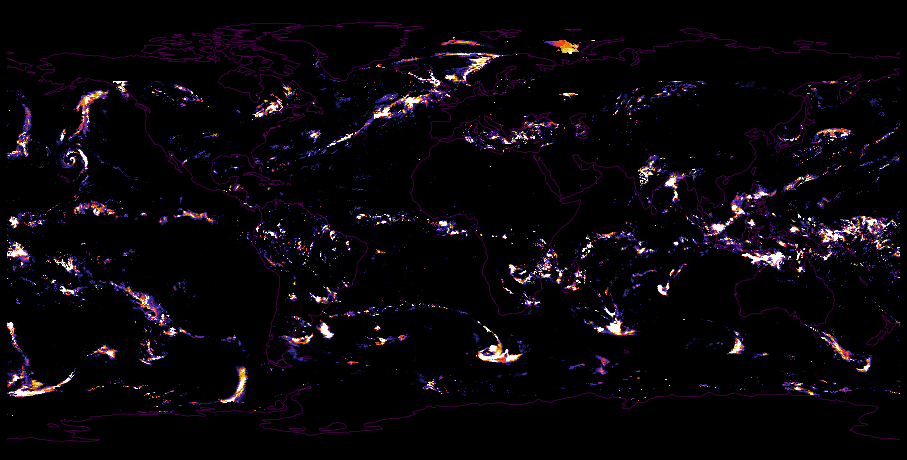

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

plt.style.use(["dark_background", "fast"])

fig = plt.figure(figsize=(16, 9))

ax = plt.axes(projection=ccrs.PlateCarree())
im = day[0].T.plot(
    ax=ax,
    add_colorbar=False,
    add_labels=False,
    transform=ccrs.PlateCarree(),
    cmap="CMRmap",
    vmax=2,
    vmin=0,
)

ax.coastlines(color="purple", alpha=0.8, linewidth=0.6)
ax.set_axis_off()

This can be turned into an animation with the following snippet.

```python
import matplotlib.animation
import numpy as np


def animate(i):
    arr = day[i].T.data.ravel()
    arr2 = np.ma.masked_array(arr, mask=np.isnan(arr))
    im.set_array(arr2)
    return (im,)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=10)  # frames=len(day) to make it longer
ani.save(
    "imerg.mp4",
    fps=15,
    extra_args=["-vcodec", "libx264"],
    savefig_kwargs=dict(pad_inches=0, transparent=False),
);

from IPython.display import Video

Video("imerg.mp4", html_attributes="controls loop autoplay")
```

Here's a similar animation for a month's worth of data:

<video controls width="80%" src="https://ai4edatasetspublicassets.blob.core.windows.net/assets/pc_video/pc-examples-imerg-long.webm">
</video>